In [1]:
from commonfunctions import *
from sklearn import svm, datasets
import sklearn.model_selection as model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from scipy.signal import argrelextrema
import cv2
import os
from skimage.filters import threshold_mean
from skimage import transform
from skimage.color import rgb2gray

In [2]:
######## return hog features from input image #########
def extract_hog_features(img):
    target_img_size = (64, 64)
    img = cv2.resize(img, target_img_size)
    win_size = (64, 64)
    cell_size = (8, 8)
    block_size_in_cells = (2, 2)
    
    block_size = (block_size_in_cells[1] * cell_size[1], block_size_in_cells[0] * cell_size[0])
    block_stride = (cell_size[1], cell_size[0])
    nbins = 9  # Number of orientation bins
    hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, nbins)
    h = hog.compute(img)
    h = h.flatten()
    return h.flatten()

In [3]:
####### return hog features from arr of images ###########
def feature_extraction_hog(images):
    feature = []
    for img in images:
        img = img.astype('uint8')
        img = cv2.resize(img, (64, 64), cv2.INTER_AREA)
        featuresHog = extract_hog_features(img.astype('uint8'))
        feature.append(featuresHog)
    return feature

In [4]:
######## binarize image ##########
def local_binarize(img, block_size = 35, offset_val = 10):
    img=img_as_ubyte(img)
    return img < threshold_otsu(img)


In [5]:
###### function that takes the folder of the dataset then returns array of images and their labels ########
def load_images_from_folder(folders):
    images = []
    y=[]
    i = 1
    for folder in folders:   
        for filename in os.listdir(folder):
            img = io.imread(os.path.join(folder,filename), as_gray = True)
            if img is not None:

                images.append(local_binarize(img))
                y.append(i)
        i+=1
    return images, y

In [6]:
############### function that extracts hog features from dataset ###################
def process_Hog():
    
    images, y = load_images_from_folder(["N:\Downloads\ACdata_base\\1","N:\Downloads\ACdata_base\\2","N:\Downloads\ACdata_base\\3","N:\Downloads\ACdata_base\\4","N:\Downloads\ACdata_base\\5","N:\Downloads\ACdata_base\\6","N:\Downloads\ACdata_base\\7","N:\Downloads\ACdata_base\\8","N:\Downloads\ACdata_base\\9"])
    features = feature_extraction_hog(images)
    return features, y

In [7]:
################# demo test for hog extraction from dataset using support vector machine
X, y = process_Hog()
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2
poly = svm.SVC(kernel='rbf', degree=3, C=5).fit(X_train, y_train)
poly_pred = poly.predict(X_test)
poly_accuracy = accuracy_score(y_test, poly_pred)
poly_f1 = f1_score(y_test, poly_pred, average='weighted')
print('Accuracy (Polynomial Kernel): ', "%.2f" % (poly_accuracy*100))
print('F1 (Polynomial Kernel): ', "%.2f" % (poly_f1*100))


Accuracy (Polynomial Kernel):  86.05
F1 (Polynomial Kernel):  85.88


In [8]:
####### function that returns the row of the text basline #######
def baseline(img):
    horizontal_projection = np.sum(img, axis=1)
    return np.argmax(horizontal_projection)


In [9]:
######### takes binary image and returns skeleton, edge, text-only, diacretecs image
def processing_images(binary_img):
    bw_img=binary_img
    baseline_i=baseline(bw_img)
    seeds=[]
    for j in range(bw_img.shape[1]-1):
        if(bw_img[baseline_i][j]==False and bw_img[baseline_i][j+1]==True):
            seeds.append(j+1)
    diacritics = bw_img
    for j in seeds:
        diacritics = flood_fill(diacritics, (baseline_i, j), False)
    text_only = bw_img != diacritics
    sobel_img = sobel(bw_img)
    skeletonized_img=skeletonize(bw_img)
    
    return sobel_img, skeletonized_img, diacritics, text_only

In [10]:
####### function that returns num of horizontal and vertical lines
def HVSL(bw_image):
    # hough line to detect lines in the photo
    tested_angles = np.linspace(np.pi, np.pi / 2, 2)
    h, theta, d = hough_line(bw_image, theta=tested_angles)
    origin = np.array((0, bw_image.shape[1]))
    # hough peaks to get those lines
    angles=[]
    for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
        y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
        angles.append(angle)
    angles = [angle * 180 / np.pi for angle in angles]
    return angles.count(90.0), angles.count(180.0)



In [11]:
################### 1st feature ##################
def HVSL_features(edge):
    vertical_lines, horizontal_lines = HVSL(edge)
    ratio_pixels_HVL = np.count_nonzero(edge)/(vertical_lines + horizontal_lines)
    vertical_lines, horizontal_lines, ratio_pixels_HVL
    print(ratio_pixels_HVL)
    print(vertical_lines, "vertical lines", horizontal_lines)

In [16]:
def text_height_feature(skeleton):
    skeleton = img_as_ubyte(skeleton)
    kernel_vertical_line=np.ones((5,1))
    line = cv2.morphologyEx(skeleton, cv2.MORPH_OPEN, kernel_vertical_line)
    line=line/255
    start_height=0
    end_height=0
    for i in range(line.shape[0]):
        if(np.any((line[i] == 1))):
            start_height = i
            break
    for i in range(line.shape[0]-1, 0, -1):
        if(np.any((line[i] == 1))):
            end_height = i
            break
    text_height = abs(start_height-end_height)
    print(text_height)
    return text_height
    show_images([line],['line'])



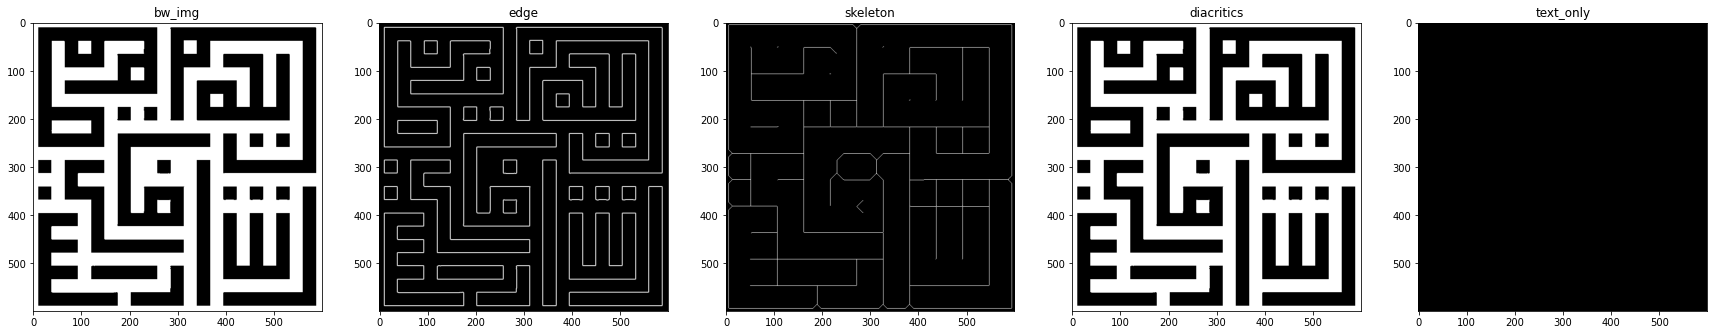

1558.2941176470588
5 vertical lines 12
586


586

In [17]:
img = io.imread('N:\Downloads\ACdata_base\\9\\1496.jpg', 1)
bw_img=local_binarize(img)
edge, skeleton, diacritics, text_only=processing_images(bw_img)
show_images([bw_img, edge, skeleton, diacritics, text_only],['bw_img', 'edge', 'skeleton', 'diacritics', 'text_only'])

################### 1st feature ##################
HVSL_features(edge)
################## 3st feature ###################
text_height_feature(skeleton)



###############################
# line_width, line_space, _ = find_ref_lengths(bw_img)
# max_vertical_line_height, _, _ = find_ref_lengths(line)
# print(max_vertical_line_height,"max")
####################################
